### Bayesian Optimization

$$\max_{x} f(x)$$
- **Motivation**
    - This is a typical machine learning task. 
    - But what if the gradient of a function with respect to x is unknown? e.g. learning rate, batch size, etc
    - Should we grid/random search all the possible space?
    - Sometimes evaluating f(x) could be very expensive. (for NN, testing a single set of hyperparameters would take 10 hours)
- Bayesian optimization try to find the global optimimum in a minimum number of steps. Bayesian optimization incorporates prior belief about f and updates the prior with samples drawn from f to get a posterior that better approximates f. 
- The model used for approximating the objective function is called surrogate model. Bayesian optimization also uses an acquisition function that directs sampling to areas where an improvement over the current best observation is likely.

###### Surrogate model 

- It approximate the true f(x).
- It's cheap to evaluate. 
- Let's use GP as a surrogate model. The GP posterior is cheap to evaluate and is used to propose points in the search space.

###### Acquisition function

- Proposing sampling points in the search space is done by acquisition functions
- The exploration, exploitation trade-off is a dilemma we face in optimization.
    - Explore: Search in regions with high uncertainty. 
    - Exploit: Search in regions with high expectation. 

- The true objective function $f$ will be evaluated at $\mathbf{x}_t = \operatorname{argmax}_{\mathbf{x}} u(\mathbf{x} \lvert \mathcal{D}_{1:t-1})$ where $u$ is the acquisition function and $\mathcal{D}_{1:t-1} = \{(\mathbf{x}_1, y_1),...,(\mathbf{x}_{t-1}, y_{t-1})\}$ are the $t-1$ samples drawn from $f$ so far.
- Acquisition functions: maximum probability of improvement (MPI), expected improvement(EI) and upper confidence bound(UCB). 
- In this implementation, we will use the expected improvement (EI) which is most widely used.

In [1]:
import numpy as np

%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

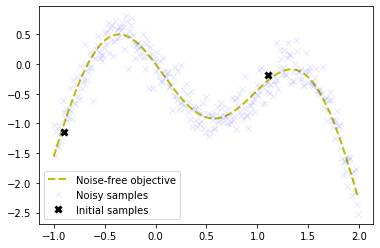

In [2]:
import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

<p>The improvement at 
$x$ 
can be expressed as follows</p>

<p>$I(x) = \max(Y - f^*,0)$</p>

<p>where $Y$ is the predictive distribution for a new data point $x$. $Y \sim \mathcal{N}(\mu, \sigma^2)$. 
<br>Expected improvement $($EI$)$ to assess $x$:</p>

<p>$EI(x) =  E_{Y\sim \mathcal{N}(\mu, \sigma^2)}[I(x)]$</p>

<p>With the reparameterization trick, $Y=\mu + \sigma \epsilon$ where 
$\epsilon\sim\mathcal{N}(0,1)$,</p>

<p>$EI(x) =  E_{\epsilon\sim \mathcal{N}(0,1)}[I(x)]$</p>

$EI(x) = \int_{-\infty}^{\infty} I(x) \phi(\epsilon) d\epsilon$, where $\phi(\epsilon)$ is the PDF of $N(0,1)$.

$EI(x)=(\mu-f^*)\Phi(\frac{\mu-f^*}{\sigma}) + \sigma
  \phi(\frac{\mu-f^*}{\sigma})$
  
<center>*more proof: http://ash-aldujaili.github.io/blog/2018/02/01/ei/</center>

In [3]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, X_sample.shape[1])
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        improvement = mu - mu_sample_opt - xi
        Z = improvement / sigma
        EI = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        EI[sigma == 0.0] = 0.0

    return EI

In [4]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(fun=min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        # fun: function to minimize,
        # x0: initial guess,
        # init point를 uniform[-1,2]에서 랜덤 추출해서 25번 반복하여 acquisition function의 max를 구한다.
        # true objective의 max를 구하는 대신 acquisition의 max를 구하는 문제로 바뀌었지만 a lot faster.
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x # argmax를 return           
            
    return min_x.reshape(-1, 1)

In [5]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

- Bayesian optimization algorithm
    1. Fit a GP model to existing data points.
    2. Propose next location, $x_*$, by maximizing acquisition function. 
    3. Evaluate true objective at the proposed point. $y_* = f(x_*)$
    4. add $(x_*, y_*)$ to the existing data points. Repeat 1-4.

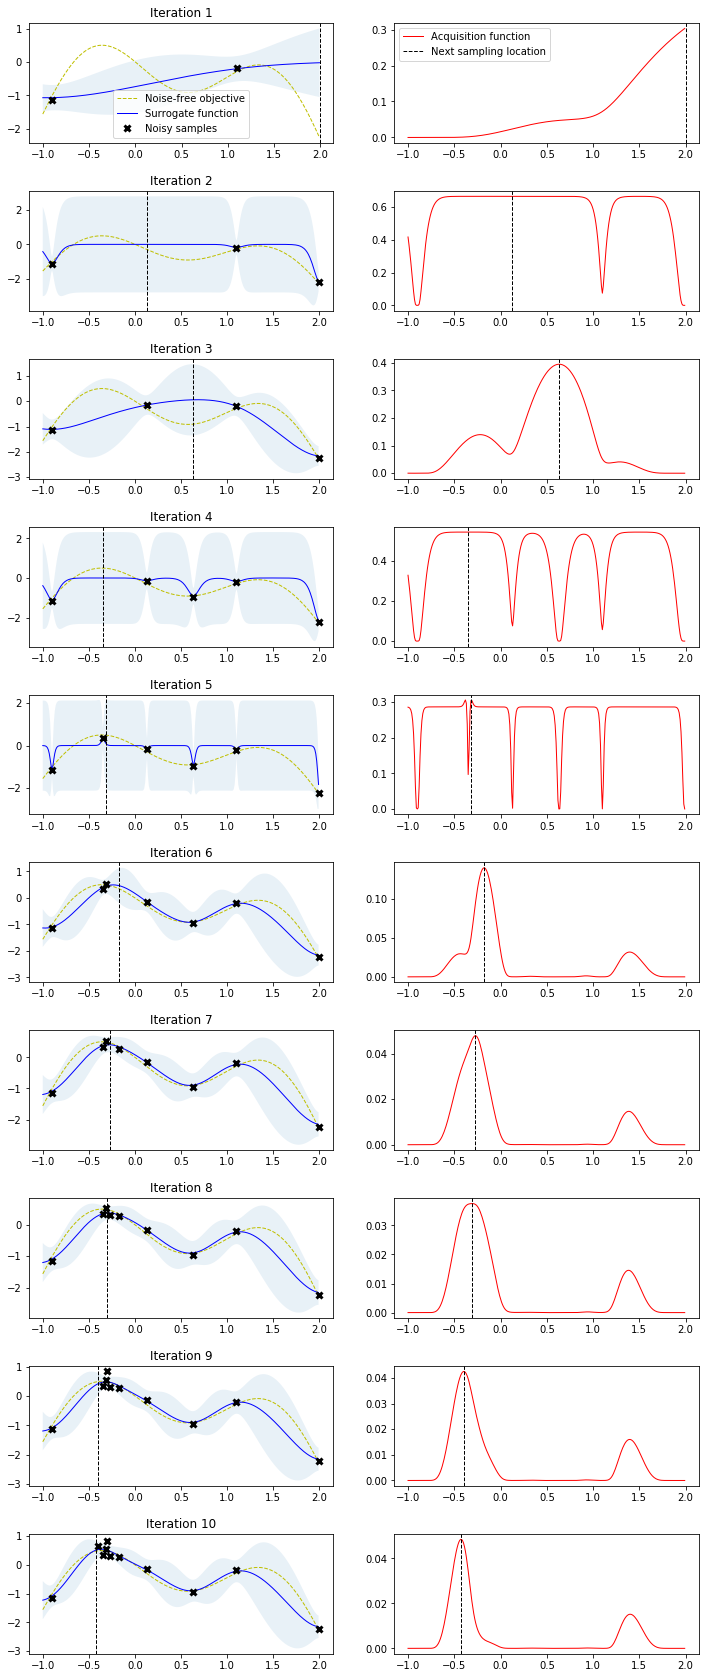

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))  # 새로 얻은 obsevation을 추가해서 GP를 fitting 시킴.
    Y_sample = np.vstack((Y_sample, Y_next))

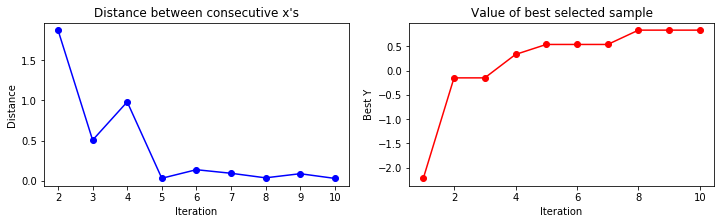

In [7]:
plot_convergence(X_sample, Y_sample)

###### Bayesian optimization libraries

- Scikit-optimize

/home/ecube_server2/.conda/envs/torch/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


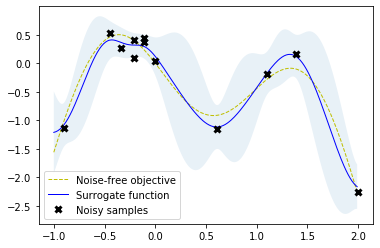

In [8]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

import warnings
warnings.filterwarnings(action='ignore')

# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

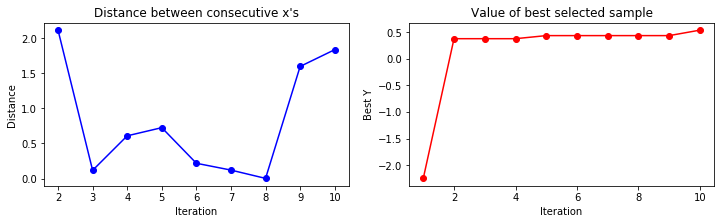

In [9]:
plot_convergence(np.array(r.x_iters), -r.func_vals)

###### GPyOpt

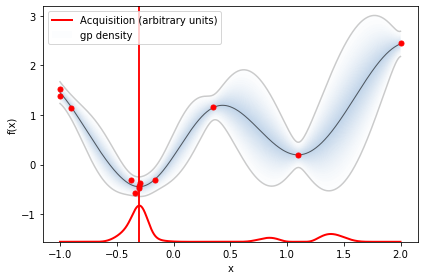

In [10]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()

##### optimize the hyperparameters

In [11]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from xgboost import XGBRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor(objective='reg:squarederror')

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()

- For hyperparameter tuning with random search, we use RandomSearchCV of scikit-learn and compute a cross-validation score for each randomly selected point in hyperparameter space.

In [12]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, Y);

- To tune hyperparameters with Bayesian optimization we implement an objective function cv_score that takes hyperparameters as input and returns a cross-validation score.
- On average, Bayesian optimization finds a better optimium in a smaller number of steps than random search and beats the baseline in almost every run. This trend becomes even more prominent in higher-dimensional search spaces. Here, the search space is 5-dimensional which is rather low to substantially profit from Bayesian optimization. One advantage of random search is that it is trivial to parallelize. Parallelization of Bayesian optimization is much harder and subject to research

In [13]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              objective='reg:squarederror',
                              min_child_weight = parameters[4]), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

Baseline neg. MSE = -3498.95
Random search neg. MSE = -3607.70
Bayesian optimization neg. MSE = -3120.16


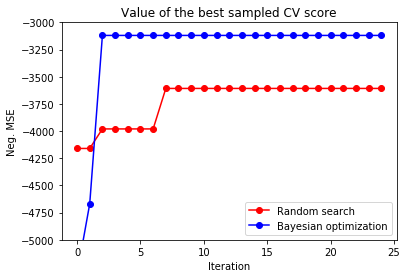

In [14]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();